In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Dropout, Bidirectional, Masking
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from sklearn.metrics import roc_curve

Epoch 1/2
4399/4399 ━━━━━━━━━━━━━━━━━━━━ 3365s 761ms/step - accuracy: 0.9201 - auc: 0.9843 - loss: 0.1311 - precision: 0.1273 - recall: 0.9803 - val_accuracy: 0.9915 - val_auc: 0.9999 - val_loss: 0.0124 - val_precision: 0.4948 - val_recall: 1.0000
Epoch 2/2
4399/4399 ━━━━━━━━━━━━━━━━━━━━ 3379s 761ms/step - accuracy: 0.9896 - auc: 0.9994 - loss: 0.0258 - precision: 0.4449 - recall: 0.9900 - val_accuracy: 0.9955 - val_auc: 1.0000 - val_loss: 0.0063 - val_precision: 0.6491 - val_recall: 1.0000
35190/35190 ━━━━━━━━━━━━━━━━━━━━ 1277s 36ms/step
8798/8798 ━━━━━━━━━━━━━━━━━━━━ 322s 37ms/step


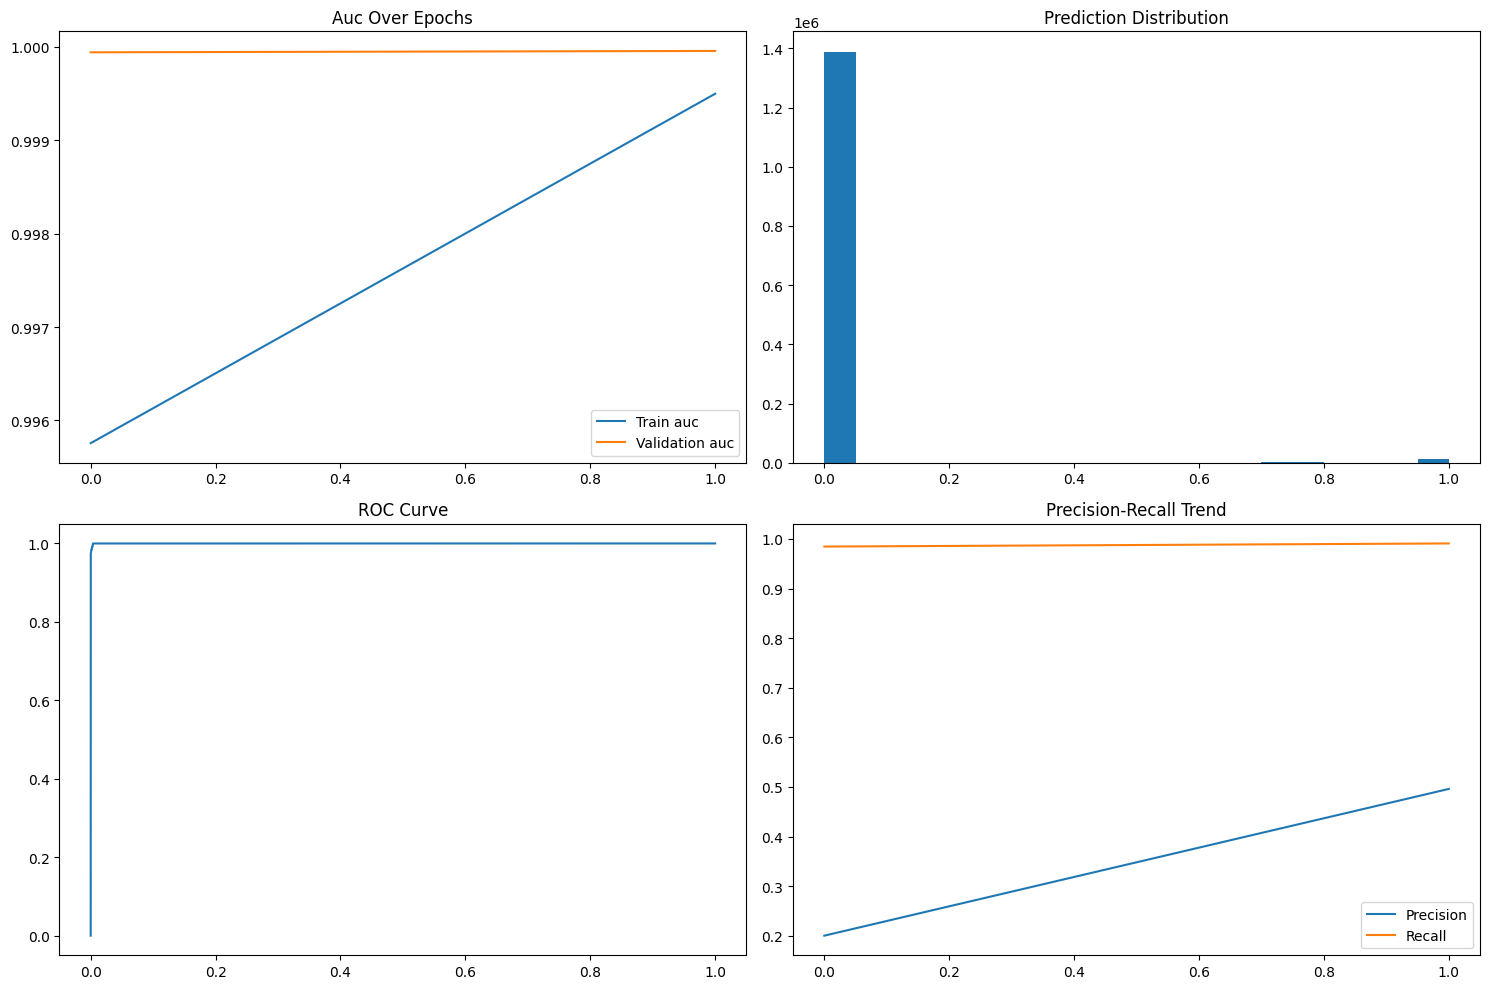

In [ ]:



class DataProcessor:
    def __init__(self, seq_length=20):
        self.seq_length = seq_length
        self.scaler = MinMaxScaler()
        self.category_scaler = MinMaxScaler()
        self.item_properties = None
        self.category_tree = None
        self.max_price = 1
        self.file_paths = {
            'category_tree': '/content/drive/MyDrive/Tap_project/category_tree.csv',
            'events': '/content/drive/MyDrive/Tap_project/events.csv',
            'item_properties_part1': '/content/drive/MyDrive/Tap_project/item_properties_part1.csv',
            'item_properties_part2': '/content/drive/MyDrive/Tap_project/item_properties_part2.csv'
        }
        self._load_data()
        self._process_data()

    def _load_data(self):
        try:
            self.category_tree = pd.read_csv(self.file_paths['category_tree'])
            self.category_tree['parentid'] = self.category_tree['parentid'].fillna(-1).astype(int)
            props1 = pd.read_csv(self.file_paths['item_properties_part1'])
            props2 = pd.read_csv(self.file_paths['item_properties_part2'])
            self.item_properties = pd.concat([props1, props2])
            self.item_properties = self.item_properties[
                self.item_properties['property'].str.lower().isin(['categoryid', 'price'])
            ]
        except FileNotFoundError as e:
            print(f"Error loading file: {str(e)}")
            print("Verify the following file paths exist:")
            for k, v in self.file_paths.items():
                print(f"{k}: {v}")
            raise

    def _process_data(self):
        latest_props = (self.item_properties.sort_values('timestamp')
                        .groupby(['itemid', 'property'])['value']
                        .last()
                        .unstack()
                        .reset_index()
                        .rename(columns=str.lower))
        for col in ['price', 'categoryid']:
            if col not in latest_props:
                latest_props[col] = 0.0 if col == 'price' else 0
        latest_props['price'] = pd.to_numeric(latest_props['price'], errors='coerce').fillna(0)
        latest_props['categoryid'] = pd.to_numeric(latest_props['categoryid'], errors='coerce').fillna(0).astype(int)
        self.item_data = latest_props.merge(self.category_tree,
                                          left_on='categoryid',
                                          right_on='categoryid',
                                          how='left')
        self.item_data['parentid'] = self.item_data['parentid'].fillna(-1).astype(int)
        events = pd.read_csv(self.file_paths['events'])
        events['timestamp'] = pd.to_datetime(events['timestamp'])
        self.full_data = events.merge(self.item_data, on='itemid', how='left')
        self.full_data['price'] = self.full_data['price'].fillna(0)
        self.full_data['categoryid'] = self.full_data['categoryid'].fillna(0)
        self.full_data['parentid'] = self.full_data['parentid'].fillna(-1)

    def get_sequences(self):
        self.max_price = max(self.full_data['price'].max(), 1)
        self.full_data['price_norm'] = self.full_data['price'] / self.max_price
        self.category_scaler.fit(self.full_data[['categoryid', 'parentid']])
        self.full_data[['cat_norm', 'parent_norm']] = self.category_scaler.transform(
            self.full_data[['categoryid', 'parentid']]
        )
        sequences = []
        targets = []
        for _, group in self.full_data.groupby('visitorid'):
            group = group.sort_values('timestamp')
            seq = []
            has_purchase = 0
            for _, row in group.iterrows():
                event_vec = np.zeros(3)
                if row['event'] == 'view':
                    event_vec[0] = 1
                elif row['event'] == 'addtocart':
                    event_vec[1] = 1
                elif row['event'] == 'transaction':
                    event_vec[2] = 1
                    has_purchase = 1
                features = np.concatenate([
                    event_vec,
                    [row['cat_norm'], row['price_norm']]
                ])
                seq.append(features)
            if len(seq) > self.seq_length:
                seq = seq[-self.seq_length:]
            else:
                pad = [np.zeros(5) for _ in range(self.seq_length - len(seq))]
                seq = pad + seq
            sequences.append(np.array(seq))
            targets.append(has_purchase)
        return np.array(sequences), np.array(targets)

class EnhancedPredictor:
    def __init__(self, seq_length=20, feature_dim=5):
        inputs = Input(shape=(seq_length, feature_dim))
        x = Masking(mask_value=0.0)(inputs)
        x = Bidirectional(LSTM(128, return_sequences=True,
                             dropout=0.3, recurrent_dropout=0.2))(x)
        x = tf.keras.layers.MultiHeadAttention(
            num_heads=4,
            key_dim=32,
            dropout=0.2
        )(x, x)
        x = LSTM(64, dropout=0.2)(x)
        x = Dropout(0.4)(x)
        x = Dense(32, activation='relu')(x)
        outputs = Dense(1, activation='sigmoid')(x)
        self.model = Model(inputs, outputs)
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008),
            loss='binary_crossentropy',
            metrics=['accuracy',
                    tf.keras.metrics.AUC(name='auc'),
                    tf.keras.metrics.Precision(name='precision'),
                    tf.keras.metrics.Recall(name='recall')]
        )

    def train(self, X_train, y_train, X_val, y_val, class_weights, epochs=2):
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=256,
            class_weight=class_weights,
            callbacks=[
                EarlyStopping(
                    monitor='val_auc',
                    patience=7,
                    mode='max',
                    restore_best_weights=True
                )
            ]
        )
        return history

class EnhancedDashboard:
    def __init__(self):
        plt.ion()
        self.fig, self.axs = plt.subplots(2, 2, figsize=(15, 10))
        self.metrics = {
            'loss': [],
            'auc': [],
            'precision': [],
            'recall': []
        }

    def update(self, history, probs, y_true):
        for idx, metric in enumerate(['loss', 'auc']):
            self.axs[0,0].clear()
            self.axs[0,0].plot(history.history[metric], label=f'Train {metric}')
            self.axs[0,0].plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
            self.axs[0,0].set_title(f'{metric.capitalize()} Over Epochs')
            self.axs[0,0].legend()
        self.axs[0,1].clear()
        self.axs[0,1].hist(probs, bins=20, range=(0, 1))
        self.axs[0,1].set_title('Prediction Distribution')
        self.axs[1,0].clear()
        fpr, tpr, _ = roc_curve(y_true, probs)
        self.axs[1,0].plot(fpr, tpr)
        self.axs[1,0].set_title('ROC Curve')
        self.axs[1,1].clear()
        self.axs[1,1].plot(history.history['precision'], label='Precision')
        self.axs[1,1].plot(history.history['recall'], label='Recall')
        self.axs[1,1].set_title('Precision-Recall Trend')
        self.axs[1,1].legend()
        plt.tight_layout()
        plt.draw()
        plt.pause(0.01)

def main():
    processor = DataProcessor(seq_length=20)
    X, y = processor.get_sequences()
    X_train, X_val, y_train, y_val = train_test_split(
        X, y,
        test_size=0.2,
        stratify=y,
        random_state=42
    )
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights = {i: w for i, w in enumerate(class_weights)}
    predictor = EnhancedPredictor()
    dashboard = EnhancedDashboard()
    history = predictor.train(X_train, y_train, X_val, y_val, class_weights)
    train_probs = predictor.model.predict(X_train).flatten()
    val_probs = predictor.model.predict(X_val).flatten()
    dashboard.update(history, np.concatenate([train_probs, val_probs]), np.concatenate([y_train, y_val]))
    predictor.model.save('enhanced_predictor.keras')
    plt.ioff()
    plt.show()

if __name__ == "__main__":
    main()

35190/35190 ━━━━━━━━━━━━━━━━━━━━ 1270s 36ms/step
8798/8798 ━━━━━━━━━━━━━━━━━━━━ 317s 36ms/step


<ipython-input-6-5d8645ecb5f2>:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  train_auc = np.trapz(train_tpr, train_fpr)
<ipython-input-6-5d8645ecb5f2>:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  val_auc = np.trapz(val_tpr, val_fpr)


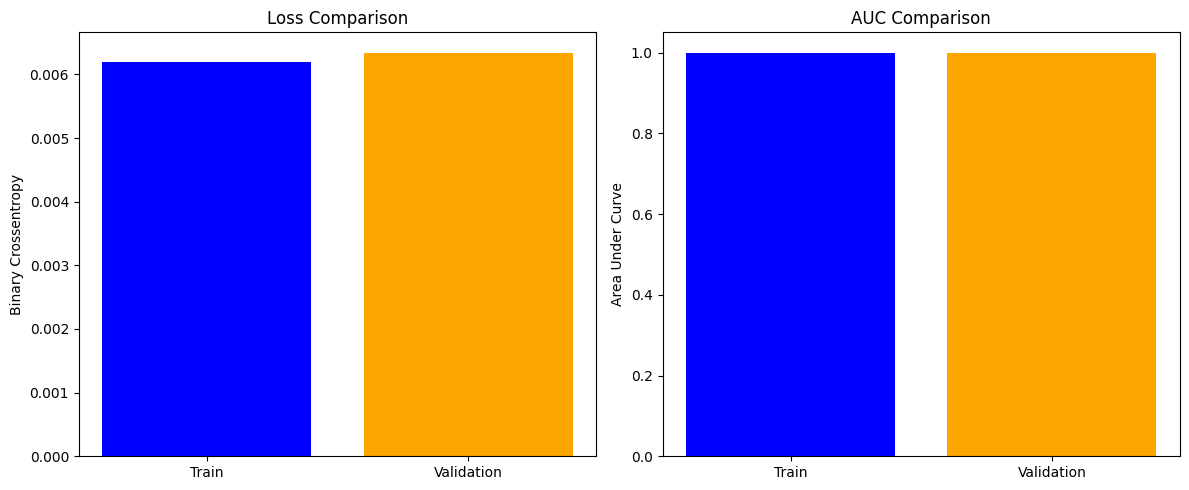

Train Loss: 0.0062 | Val Loss: 0.0063
Train AUC:  1.0000 | Val AUC:  1.0000

✅ Model generalization looks good!


In [ ]:
def load_and_evaluate(model_path):
    model = tf.keras.models.load_model(model_path)

    processor = DataProcessor(seq_length=20)
    X, y = processor.get_sequences()

    X_train, X_val, y_train, y_val = train_test_split(
        X, y,
        test_size=0.2,
        stratify=y,
        random_state=42
    )

    train_probs = model.predict(X_train).flatten()
    val_probs = model.predict(X_val).flatten()

    train_loss = tf.keras.losses.binary_crossentropy(y_train, train_probs).numpy().mean()
    val_loss = tf.keras.losses.binary_crossentropy(y_val, val_probs).numpy().mean()

    train_fpr, train_tpr, _ = roc_curve(y_train, train_probs)
    val_fpr, val_tpr, _ = roc_curve(y_val, val_probs)
    train_auc = np.trapz(train_tpr, train_fpr)
    val_auc = np.trapz(val_tpr, val_fpr)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.bar(['Train', 'Validation'], [train_loss, val_loss], color=['blue', 'orange'])
    plt.title('Loss Comparison')
    plt.ylabel('Binary Crossentropy')

    plt.subplot(1, 2, 2)
    plt.bar(['Train', 'Validation'], [train_auc, val_auc], color=['blue', 'orange'])
    plt.title('AUC Comparison')
    plt.ylabel('Area Under Curve')

    plt.tight_layout()
    plt.show()

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train AUC:  {train_auc:.4f} | Val AUC:  {val_auc:.4f}")

    if val_loss > train_loss * 1.2 and val_auc < train_auc - 0.05:
        print("\nWarning: Model is overfitting!")
    else:
        print("\n✅Model generalization looks good!")

model="/content/enhanced_predictor.keras"
load_and_evaluate(model)



In [ ]:
/content/enhanced_predictor.keras